## En esta rutina se usan dos opciones de descarga de datos de ERA5 

Para la *primera opcion* es necesario estar logueado en Copernicus y haver generado una key
Para la *segunda opcion* se accede a los datos que están en AWS de forma directa. 

In [1]:
# OPCION 1
import cdsapi
cds = cdsapi.Client()
cds.retrieve('reanalysis-era5-pressure-levels', {
       "variable": "temperature",
       "pressure_level": "1000",
       "product_type": "reanalysis",
       "date": "2017-12-01/2017-12-31",
       "time": "12:00",
       "format": "grib"
   }, 'download.grib')

In [ ]:
# librerias que instalé 
# pip install h5netcdf
# pip install s3fs

In [7]:
# OPCION 2 - basada en el tutorial de OHW2020
import warnings 
warnings.filterwarnings("ignore") 

import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

xr.set_options(display_style="html")  

%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [10]:
# esta funcion "descarga" los datos de ERA5 de la nube

def get_era5(var, lyr):
    syr=str(lyr).zfill(4)
    fs = s3fs.S3FileSystem(anon=True)
    if var=='all':
        file_location = fs.glob('s3://era5-pds/'+ syr +'/*/*.nc')
    else:
        file_location = fs.glob('s3://era5-pds/'+ syr +'/*/data/'+ var +'*.nc')
    file_ob = [fs.open(file) for file in file_location]        
    ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time0') 

    return ds

In [13]:
%%time

# definimos un anio de interes
lyr = 2017  

# variable de interes. El llistado de variables está en https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md
var = 'eastward_wind_at_10_metres'   

# usamos la funcion
ds = get_era5(var,lyr)
ds

CPU times: user 989 ms, sys: 150 ms, total: 1.14 s
Wall time: 5.35 s


<xarray.Dataset>
Dimensions:                     (lat: 721, lon: 1440, time0: 8760)
Coordinates:
  * lon                         (lon) float32 0.0 0.25 0.5 ... 359.5 359.75
  * lat                         (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                       (time0) datetime64[ns] 2017-01-01 ... 2017-12...
Data variables:
    eastward_wind_at_10_metres  (time0, lat, lon) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [23]:
# definimos un area de interés y recortamos el tiempo

lon_w = -80 + 360
lon_e = -52 + 360
lat_s = -50
lat_n = -25

ds_subset = ds.sel(lat=slice(lat_n,lat_s), lon=slice(lon_w,lon_e), time0=slice("2017-06-01", "2017-06-10"))
ds_subset

<xarray.Dataset>
Dimensions:                     (lat: 101, lon: 113, time0: 240)
Coordinates:
  * lon                         (lon) float32 280.0 280.25 ... 307.75 308.0
  * lat                         (lat) float32 -25.0 -25.25 ... -49.75 -50.0
  * time0                       (time0) datetime64[ns] 2017-06-01 ... 2017-06...
Data variables:
    eastward_wind_at_10_metres  (time0, lat, lon) float32 dask.array<chunksize=(240, 101, 113), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

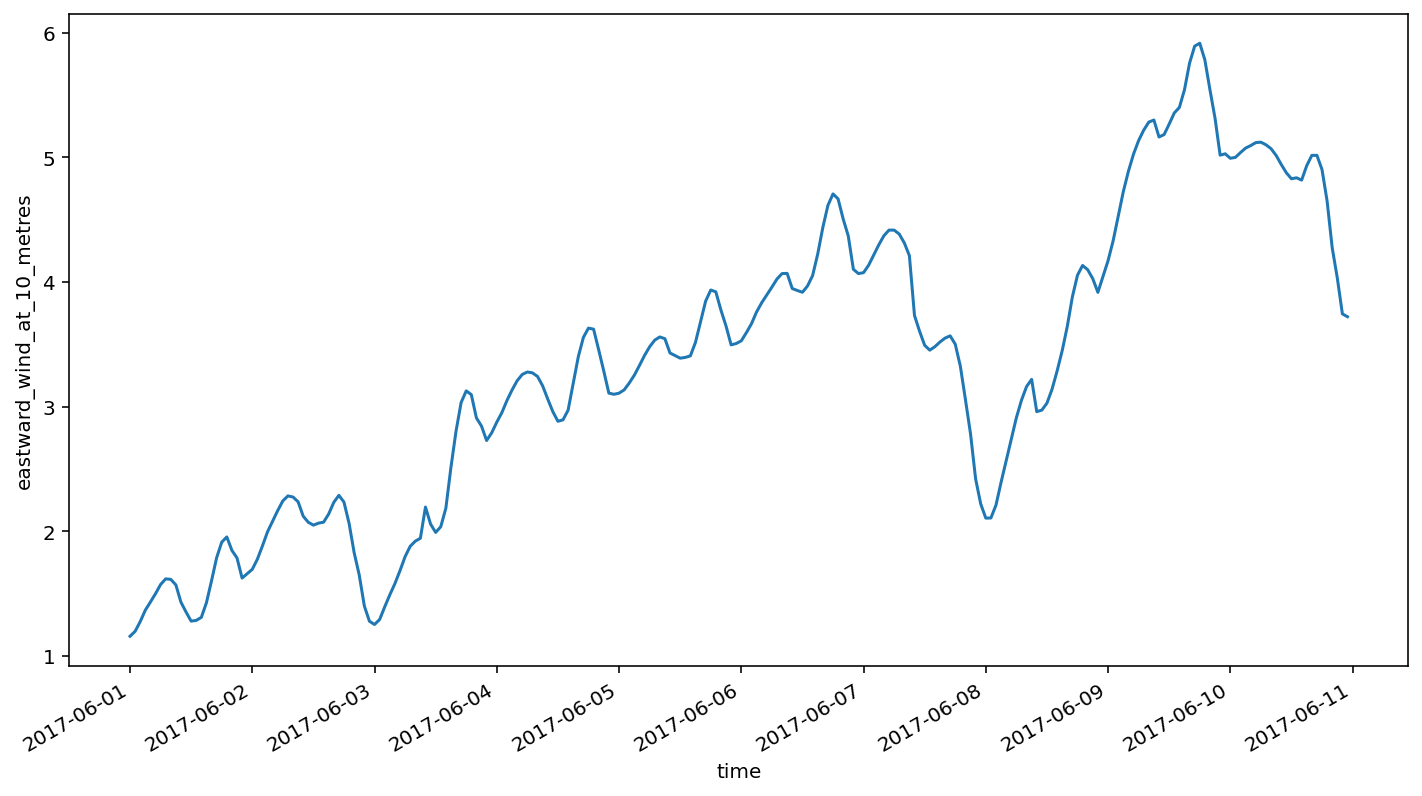

In [25]:
# realizamos un promedio espacial para poder graficar una serie temporal.

ds_subset_mean = ds_subset.mean(dim=('lat','lon'))

ds_subset_mean.eastward_wind_at_10_metres.plot()
